# 초기 세팅

In [ ]:
# font, display setting

!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [ ]:
# Khaiii 설치
!git clone https://github.com/kakao/khaiii.git #git clone
!pip install cmake
!mkdir build
!cd build && cmake /content/khaiii
!cd /content/build/ && make all
!cd /content/build/ && make resource #리소스 빌드
!cd /content/build && make install
!cd /content/build && make package_python #파이썬 바인딩
!pip install /content/build/package_python

In [ ]:
import re
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
klue = pd.read_csv('/content/drive/Shareddrives/KU 데이터톤/KLUE 크롤링/spaced.csv')
del klue['Unnamed: 0']

# 텍스트 전처리

In [ ]:
def text_cleaning(text):
    hangul = re.compile('[^ \nㄱ-ㅣ가-힣]+') #한글과 띄어쓰기, 엔터를 제외한 모든 글자 
    result = hangul.sub('', str(text))
    return(result)

def cleaned_corpus(docs):
    cleaned = []
    for sent in docs:
        cleaned.append(text_cleaning(sent))
    return cleaned

In [ ]:
# 강의 별로 한 줄씩 transaction 만들기

def review_trans(lecture_idx):
    sample = klue['cleaned'][lecture_idx].split('\n')
    sample = [s for s in sample if s]

    tmp =[]
    for s in sample:
        s = [s]
        tmp.append(s)
    
    return tmp

In [ ]:
# khaiii 품사 태깅

from khaiii import KhaiiiApi
api = KhaiiiApi()

def pos_text(texts):
    significant_tags = ['NNG', 'NNP', 'VV', 'VA', 'MM'] 
    corpus = []
    for sent in texts:
        pos_tagged = ''
        for word in api.analyze(sent):
            for morph in word.morphs:
                if morph.tag in significant_tags:
                    pos_tagged += morph.lex + '/' + morph.tag + ' '
        corpus.append(pos_tagged.strip())
    return corpus

def review_khaiii_pos(review):
    klue.dropna(axis=0, inplace=True)
    if not klue.isnull().values.any():
        pos = []
        for s in review:
            s_pos = pos_text(s)
            pos.append(s_pos)
        return pos
    else:
        print("NULL in the text")


In [ ]:
# 어간 추출

p1 = re.compile('[가-힣A-Za-z0-9]+/NN.') #보통 명사, 고유 명사
p2 = re.compile('[가-힣A-Za-z0-9]+/MM') #성상 관형사
p3 = re.compile('[가-힣A-Za-z0-9]+/VV') #동사
p4 = re.compile('[가-힣A-Za-z0-9]+/VA') #형용사

def stemming_text(text):
    corpus = []
    for sent in text:
        ori_sent = sent
        mached_terms = re.findall(p1, ori_sent) #NN
        for terms in mached_terms:
            ori_terms = terms #original
            modi_terms = '' #modified
            for term in terms.split(' '):
                lemma = term.split('/')[0] #표제어
                tag = term.split('/')[-1] #태깅된 품사
                modi_terms += lemma
            modi_terms += '/NN' #보통 명사/고유 명사
            ori_sent = ori_sent.replace(ori_terms, modi_terms)
        
        mached_terms = re.findall(p2, ori_sent)
        for terms in mached_terms:
            ori_terms = terms
            modi_terms = ''
            for term in terms.split(' '):
                lemma = term.split('/')[0]
                tag = term.split('/')[-1]
                modi_terms += lemma
            modi_terms += '/MM' #관형사
            ori_sent = ori_sent.replace(ori_terms, modi_terms)

        mached_terms = re.findall(p3, ori_sent)
        for terms in mached_terms:
            ori_terms = terms
            modi_terms = ''
            for term in terms.split(' '):
                lemma = term.split('/')[0]
                tag = term.split('/')[-1]
                modi_terms += lemma
            if '다' != modi_terms[-1]:
                modi_terms += '다'
            modi_terms += '/VV' #동사
            ori_sent = ori_sent.replace(ori_terms, modi_terms)

        mached_terms = re.findall(p4, ori_sent)
        for terms in mached_terms:
            ori_terms = terms
            modi_terms = ''
            for term in terms.split(' '):
                lemma = term.split('/')[0]
                tag = term.split('/')[-1]
                modi_terms += lemma
            if '다' != modi_terms[-1]:
                modi_terms += '다'
            modi_terms += '/VA'
            ori_sent = ori_sent.replace(ori_terms, modi_terms)
        corpus.append(ori_sent)
    return corpus


def review_stemming(text):
    stemming_corpus = []
    for p in text:
        stem = stemming_text(p)
        stemming_corpus.append(stem)
    return stemming_corpus

In [ ]:
# stemming 후 텍스트 정제

def cleaning_stemming(stemming):
    cleaned_corpus = []
    for i in range(0,len(stemming)):
        cleaned_corpus.append(text_cleaning(stemming[i]))
    
    corpus_comma=[]
    for sent in cleaned_corpus:
        corpus_comma.append(sent.split())
    
    return corpus_comma


In [ ]:
# 불용어 제거

def rm_stp(text):
    stp = ['있다','하다','주다','듣다','보다','같다','어떤','이쁘다','그','이','두','말','중', '그러다', '되다']
    corpus = []
    for sent in text:
        tmp = [w for w in sent if not w in stp]
        corpus.append(tmp)
    return corpus

# Apriori

In [ ]:
!pip install apyori
from apyori import apriori

  Created wheel for apyori: filename=apyori-1.1.2-py3-none-any.whl size=5975 sha256=6dea64ecdbde4123ac5fe61e7833472e56fb6738b0660837609bf2f5dbe38b11
  Stored in directory: /root/.cache/pip/wheels/cb/f6/e1/57973c631d27efd1a2f375bd6a83b2a616c4021f24aab84080
Successfully built apyori


In [ ]:
def network(transactions):
    results = list(apriori(transactions,
                           min_confidence=.2, min_lift=3,
                           max_length=2))
    
    columns = ['source', 'target', 'support']
    network_df = pd.DataFrame(columns=columns)

    for result in results:
        if len(result.items) == 2:
            items = [x for x in result.items]
            row = [items[0],items[1], result.support]
            series = pd.Series(row, index = network_df.columns)
            network_df = network_df.append(series, ignore_index = True)

    return network_df

In [ ]:
from collections import Counter

In [ ]:
def node(transactions):
    tr=[]
    for t in transactions:
        if t not in tr:
            tr += t
    
    count = Counter(tr)
    cnt = {x:count[x] for x in count if count[x]>1}

    node_df = pd.DataFrame(cnt.items(), columns=['node','nodesize'])

    return node_df

## 시각화

In [ ]:
import networkx as nx
import numpy as np

In [ ]:
def vis_apriori(node, network, k=None, iter=50):
    plt.figure(figsize=(16,12))

    #networkx 그래프 객체 생성
    G = nx.Graph()

    #node_df의 키워드 빈도수를 데이터로 해서, 네트워크 그래프의 노드 역할 하는 원 생성
    for index, row in node_df.iterrows():
        G.add_node(row['node'],nodesize=row['nodesize'])

    #network_df의 연관분석 데이터를 기반으로, 네트워크 그래프의 관계 역할 하는 선 생성
    for index, row in network_df.iterrows():
        G.add_weighted_edges_from([(row['source'], row['target'], row['support'])])

    #그래프 디자인 관련 파라미터
    pos = nx.spring_layout(G, k=k, iterations=iter)
    pr = nx.pagerank(G)
    nsize = np.array([v for v in pr.values()])
    nsize = 4500 * (nsize-min(nsize)) / (max(nsize)-min(nsize))


    nx.draw(G, pos=pos, node_size=nsize, alpha=0.5)

    nx.draw_networkx_labels(G, pos=pos, font_family='NanumBarunGothic', font_size=20)

    ax = plt.gca()
    plt.show()  

# 데이터에 적용

## 텍스트 전처리

In [ ]:
klue['cleaned'] = cleaned_corpus(klue['evaluation'])

In [ ]:
klue[:5]

,class_name,professor_name,work_load,level,teaching,proud,evaluation,evaluation_kor,evaluation_spaced,cleaned
0,데이터네트워크(영강),김중헌,1.7,1.9,3.7,2.8,학점은 물론 그 어떤 교수님보다 잘 주시지만 강의를 통해 배운건 별로 없는 것 같습...,학점은 물론 그 어떤 교수님보다 잘 주시지만 강의를 통해 배운건 별로 없는 것 같습...,학점은 물론 그 어떤 교수님보다 잘 주시지만 강의를 통해 배운 건 별로 없는 것 같...,학점은 물론 그 어떤 교수님보다 잘 주시지만 강의를 통해 배운건 별로 없는 것 같습...
1,디지털통신,김운경,4.4,4.3,2.6,2.6,이 강의를 이해하려면 교수의 마음을 읽어야 합니다. 산은 산이고 물은 물이라는 마음...,이 강의를 이해하려면 교수의 마음을 읽어야 합니다 산은 산이고 물은 물이라는 마음을...,이 강의를 이해하려면 교수의 마음을 읽어야 합니다 산은 산이고 물은 물이라는 마음을...,이 강의를 이해하려면 교수의 마음을 읽어야 합니다 산은 산이고 물은 물이라는 마음을...
2,디지털통신,이인규,4.4,4.4,4.1,4.0,적당히 빨리 나가면 몰라. 이렇게 빨리 설명하는데 듣기 너무 어려웠어요. 그래서 안...,적당히 빨리 나가면 몰라 이렇게 빨리 설명하는데 듣기 너무 어려웠어요 그래서 안 들...,적당히 빨리 나가면 몰라 이렇게 빨리 설명하는데 듣기 너무 어려웠어요 그래서 안 들...,적당히 빨리 나가면 몰라 이렇게 빨리 설명하는데 듣기 너무 어려웠어요 그래서 안 들...
3,디지털통신,허준,3.6,3.9,4.7,4.0,많은 사람들에게 듣던대로 강의력이 정말 좋으시고 학생들을 배려해주시는게 너무 느껴졌...,많은 사람들에게 듣던대로 강의력이 정말 좋으시고 학생들을 배려해주시는게 너무 느껴졌...,많은 사람들에게 듣던 대로 강의력이 정말 좋으시고 학생들을 배려해 주시는 게 너무 ...,많은 사람들에게 듣던대로 강의력이 정말 좋으시고 학생들을 배려해주시는게 너무 느껴졌...
4,반도체공학Ⅱ(영강),유현용,4.2,3.5,4.5,4.2,강의력은 정말 좋으십니다!! 설명을 너무너무너무너무너무 잘하십니다!!!!! 진짜 강...,강의력은 정말 좋으십니다 설명을 너무너무너무너무너무 잘하십니다 진짜 강추 중간 플젝...,강의력은 정말 좋으십니다 설명을 너무너무너무너무너무 잘하십니다 진짜 강 추 중간 플...,강의력은 정말 좋으십니다 설명을 너무너무너무너무너무 잘하십니다 진짜 강추 \n\n중...


In [ ]:
tmp79 = review_trans(79)

In [ ]:
tmp79[:5]

[['                                                수업 때  을 종종하시고 출석 체크를 매번 하셨던 것 같습니다'],
 ['수업 시간에 언급하신 것이 시험에 많이 출제됩니다'],
 ['교재는 따로 쓰시지 않으시고 교수님이 만드신 로 수업이 진행되는데 필기를 많이 하셔야합니다'],
 ['큰 발표는 딱 한 개 있는데 실험 로 진행이 돼서  가 꽤 있습니다중간 없고 기말 전범위임 에세이 문제 나옴 난이도는 쉬웠으나 수업에서 배운 이론들을 적용하는 문제가 나옴'],
 ['팀플 한 번 있는데 꼭 보장된 지인들과 들으시길']]

In [ ]:
pos79 = review_khaiii_pos(tmp79)

In [ ]:
pos79[:3]

[['수업/NNG 때/NNG 종종/NNG 출석/NNG 체크/NNG 하/VV 같/VA'],
 ['수업/NNG 시간/NNG 언급/NNG 시험/NNG 출제/NNG'],
 ['교재/NNG 쓰/VV 교수/NNG 만들/VV 로/NNG 수업/NNG 진행/NNG 필기/NNG 하/VV']]

In [ ]:
stem79 = review_stemming(pos79)

In [ ]:
stem79[:3]

[['수업/NN 때/NN 종종/NN 출석/NN 체크/NN 하다/VV 같다/VA'],
 ['수업/NN 시간/NN 언급/NN 시험/NN 출제/NN'],
 ['교재/NN 쓰다/VV 교수/NN 만들다/VV 로/NN 수업/NN 진행/NN 필기/NN 하다/VV']]

In [ ]:
clean79 = cleaning_stemming(stem79)

In [ ]:
clean79[:3]

[['수업', '때', '종종', '출석', '체크', '하다', '같다'],
 ['수업', '시간', '언급', '시험', '출제'],
 ['교재', '쓰다', '교수', '만들다', '로', '수업', '진행', '필기', '하다']]

In [ ]:
rm79 = rm_stp(clean79)

In [ ]:
rm79[:3]

[['수업', '때', '종종', '출석', '체크'],
 ['수업', '시간', '언급', '시험', '출제'],
 ['교재', '쓰다', '교수', '만들다', '로', '수업', '진행', '필기']]

## Apriori

In [ ]:
network_df = network(rm79)
node_df = node(rm79)

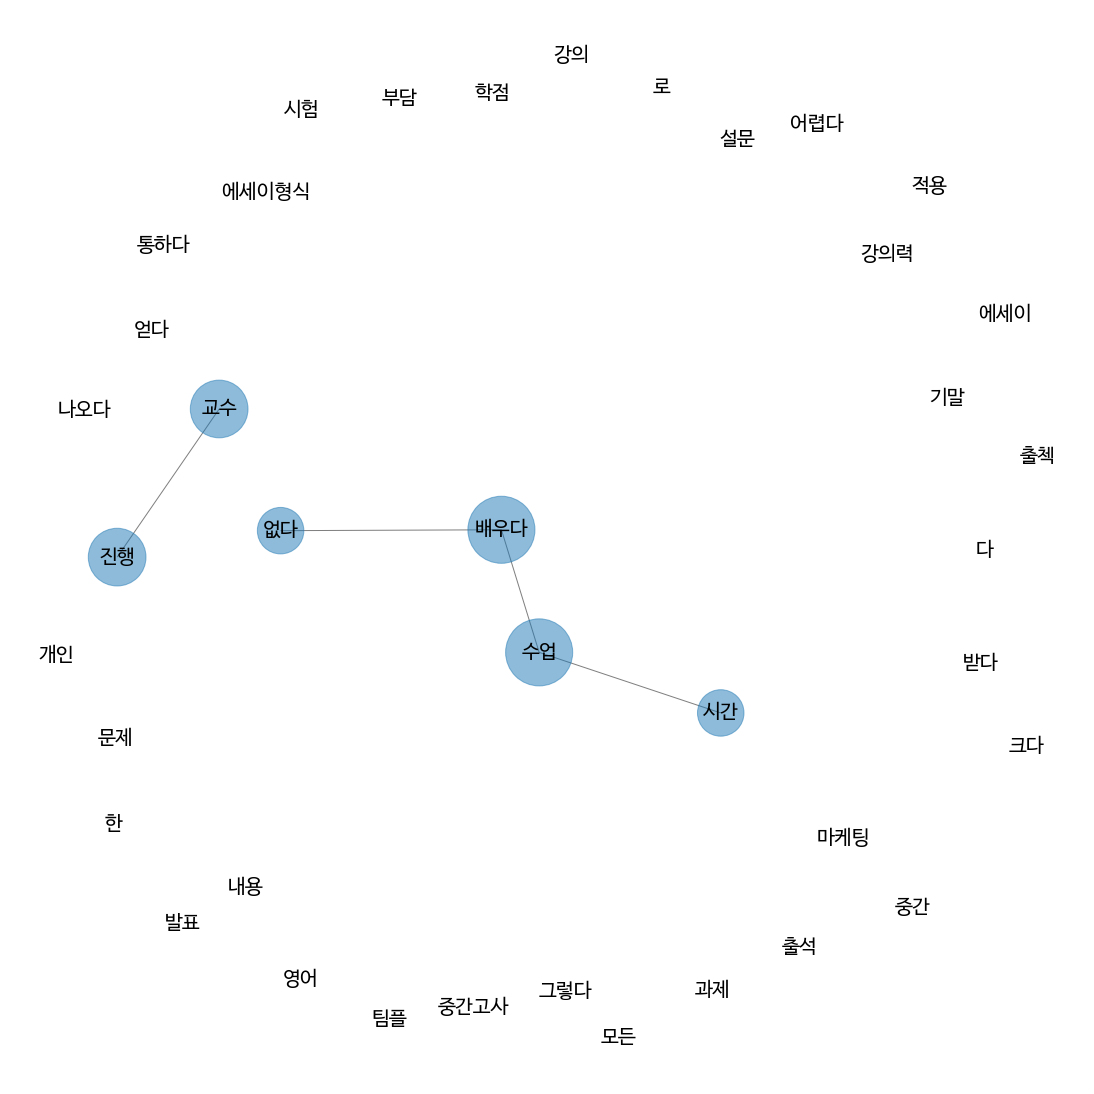

In [ ]:
vis_apriori(node_df, network_df)

# Ex 2

In [ ]:
def preprocessing(num):
    tmp = review_trans(num)
    pos = review_khaiii_pos(tmp)
    stem = review_stemming(pos)
    clean = cleaning_stemming(stem)
    rm = rm_stp(clean)
    return rm

In [ ]:
text = preprocessing(132)
network_df = network(text)
node_df = node(text)

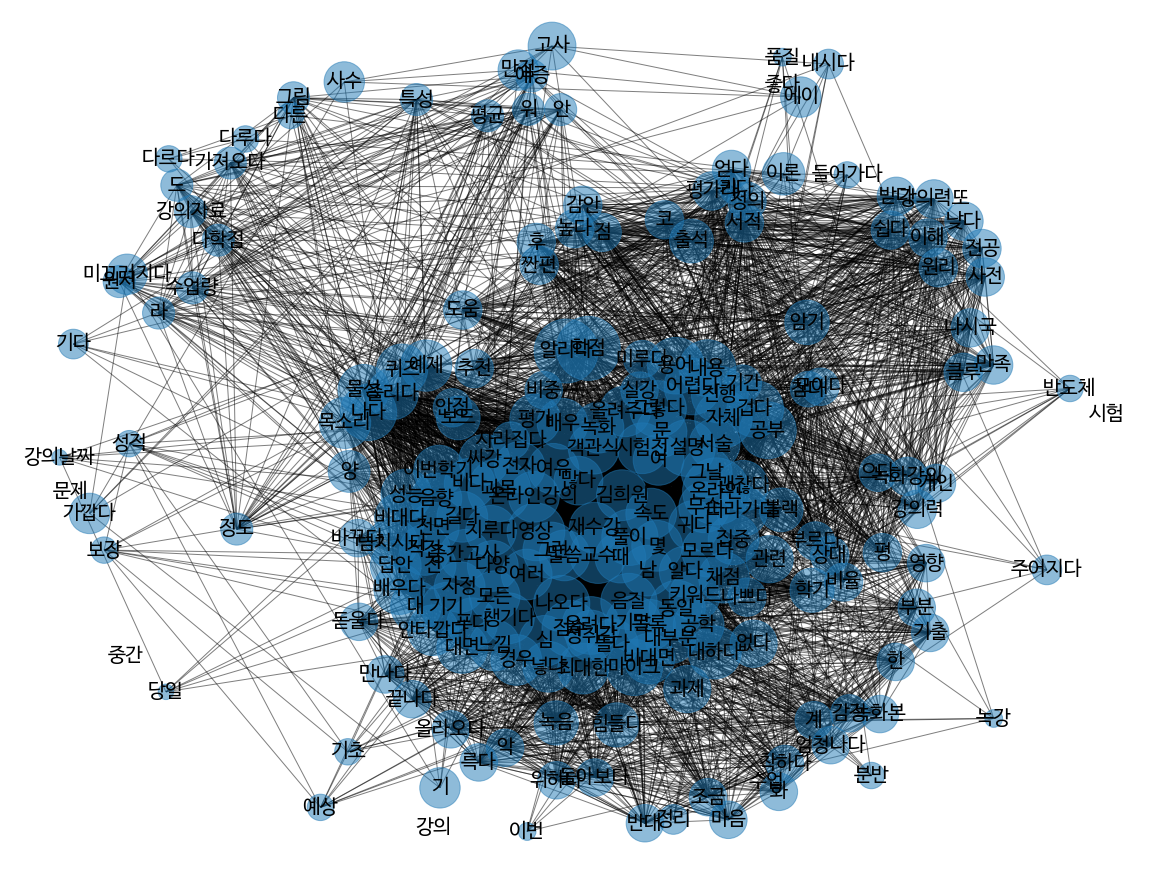

In [ ]:
vis_apriori(node_df, network_df,k=.9,iter=80)

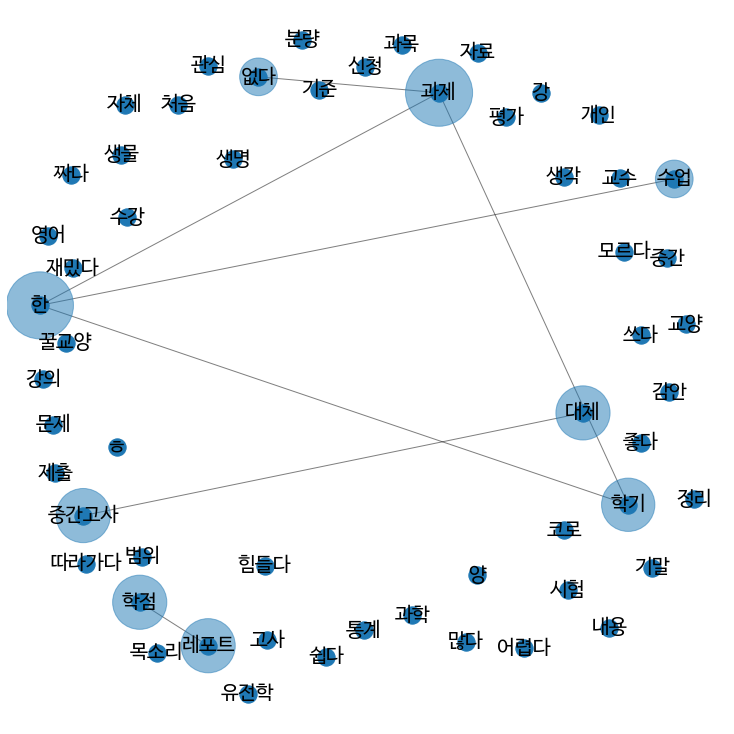

In [ ]:
plt.figure(figsize=(10,10))

#networkx 그래프 객체 생성
G = nx.Graph()

#node_df의 키워드 빈도수를 데이터로 해서, 네트워크 그래프의 노드 역할 하는 원 생성
for index, row in node_df.iterrows():
    G.add_node(row['node'],nodesize=row['nodesize'])

#network_df의 연관분석 데이터를 기반으로, 네트워크 그래프의 관계 역할 하는 선 생성
for index, row in network_df.iterrows():
    G.add_weighted_edges_from([(row['source'], row['target'], row['support'])])

#그래프 디자인 관련 파라미터
pos = nx.spring_layout(G, k=.7, iterations=20)
pr = nx.pagerank(G)
nsize = np.array([v for v in pr.values()])
nsize = 4500 * (nsize-min(nsize)) / (max(nsize)-min(nsize))


nx.draw(G, pos=pos, node_size=nsize, alpha=0.5)
nx.draw_networkx_nodes(G, pos, alpha=1)
nx.draw_networkx_labels(G, pos=pos, font_family='NanumBarunGothic', font_size=20)

ax = plt.gca()
plt.show()

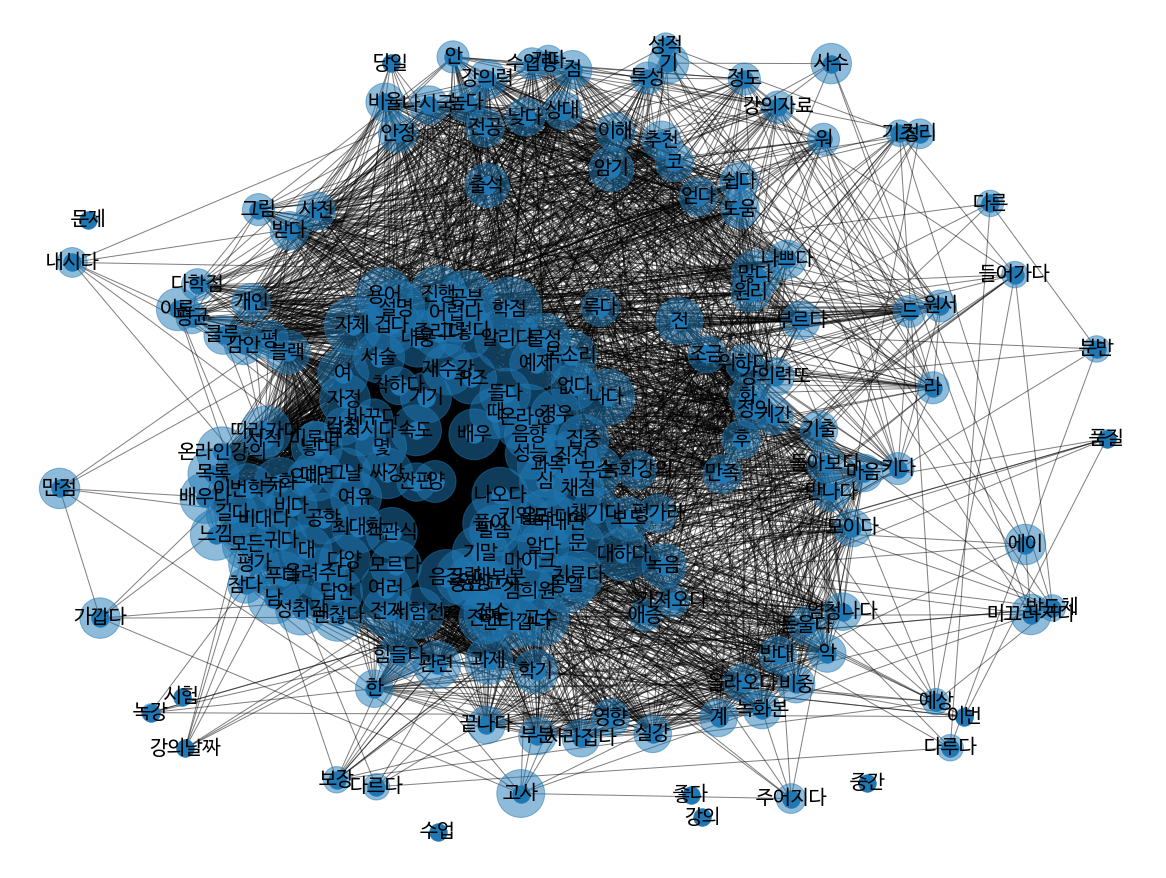

In [ ]:
plt.figure(figsize=(16,12))

#networkx 그래프 객체 생성
G = nx.Graph()

#node_df의 키워드 빈도수를 데이터로 해서, 네트워크 그래프의 노드 역할 하는 원 생성
for index, row in node_df.iterrows():
    G.add_node(row['node'],nodesize=row['nodesize'])

#network_df의 연관분석 데이터를 기반으로, 네트워크 그래프의 관계 역할 하는 선 생성
for index, row in network_df.iterrows():
    G.add_weighted_edges_from([(row['source'], row['target'], row['support'])])

#그래프 디자인 관련 파라미터
pos = nx.spring_layout(G, k=.7, iterations=60)
pr = nx.pagerank(G)
nsize = np.array([v for v in pr.values()])
nsize = 4500 * (nsize-min(nsize)) / (max(nsize)-min(nsize))


nx.draw(G, pos=pos, node_size=nsize, alpha=0.5)
nx.draw_networkx_nodes(G, pos, alpha=1)
nx.draw_networkx_labels(G, pos=pos, font_family='NanumBarunGothic', font_size=20)

ax = plt.gca()
plt.show()

# ex3

In [ ]:
print(klue['class_name'][171], "|", klue['professor_name'][171])

중급회계II | 권수영


In [ ]:
text = preprocessing(171)
network_df = network(text)
node_df = node(text)

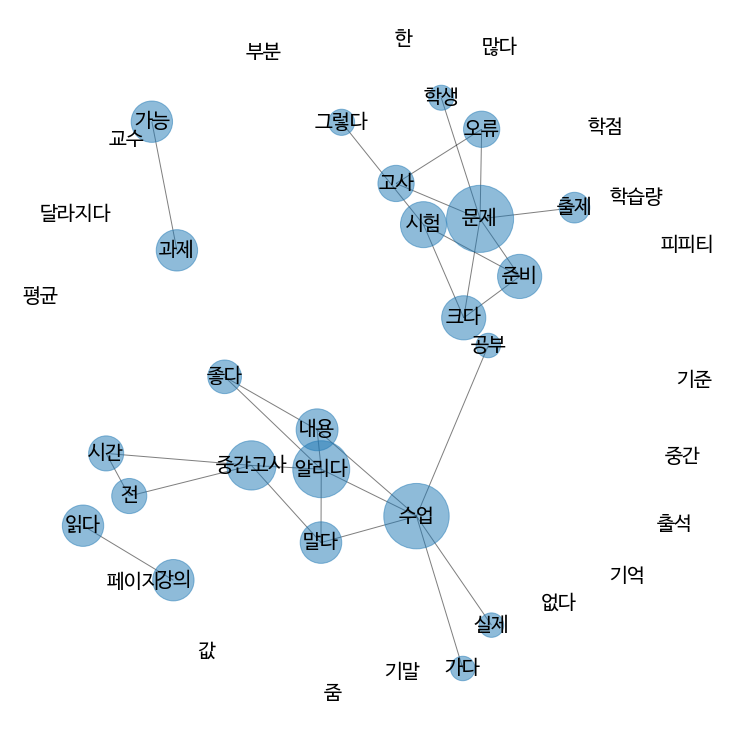

In [ ]:
plt.figure(figsize=(10,10))

#networkx 그래프 객체 생성
G = nx.Graph()

#node_df의 키워드 빈도수를 데이터로 해서, 네트워크 그래프의 노드 역할 하는 원 생성
for index, row in node_df.iterrows():
    G.add_node(row['node'],nodesize=row['nodesize'])

#network_df의 연관분석 데이터를 기반으로, 네트워크 그래프의 관계 역할 하는 선 생성
for index, row in network_df.iterrows():
    G.add_weighted_edges_from([(row['source'], row['target'], row['support'])])

#그래프 디자인 관련 파라미터
pos = nx.spring_layout(G, k=.5, iterations=100)
pr = nx.pagerank(G)
nsize = np.array([v for v in pr.values()])
nsize = 4500 * (nsize-min(nsize)) / (max(nsize)-min(nsize))


nx.draw(G, pos=pos, node_size=nsize, alpha=0.5)
nx.draw_networkx_labels(G, pos=pos, font_family='NanumBarunGothic', font_size=20)

ax = plt.gca()
plt.show()

# ex4

In [ ]:
print(klue['class_name'][74], "|", klue['professor_name'][74])

양적유전학 | 홍기창


In [ ]:
text = preprocessing(74)
network_df = network(text)
node_df = node(text)

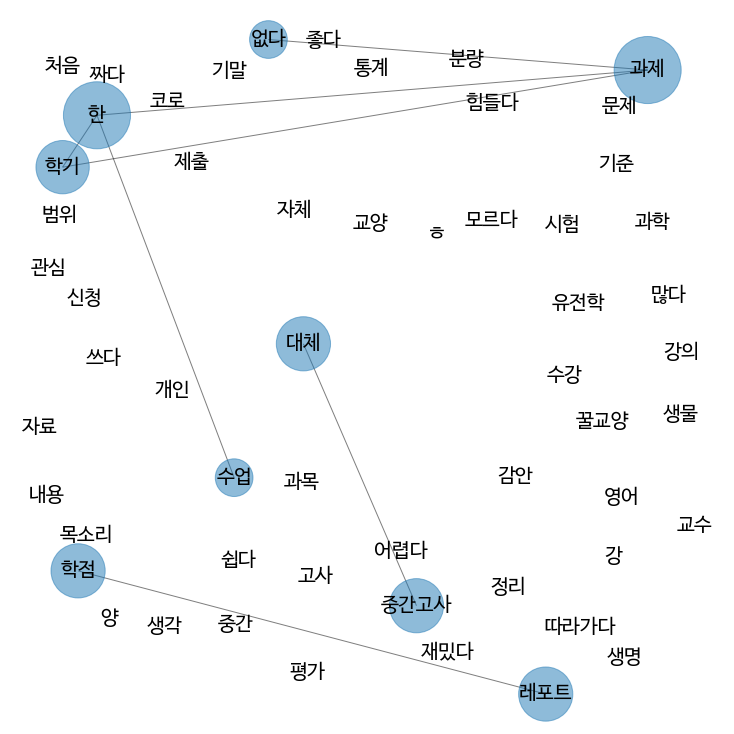

In [ ]:
plt.figure(figsize=(10,10))

#networkx 그래프 객체 생성
G = nx.Graph()

#node_df의 키워드 빈도수를 데이터로 해서, 네트워크 그래프의 노드 역할 하는 원 생성
for index, row in node_df.iterrows():
    G.add_node(row['node'],nodesize=row['nodesize'])

#network_df의 연관분석 데이터를 기반으로, 네트워크 그래프의 관계 역할 하는 선 생성
for index, row in network_df.iterrows():
    G.add_weighted_edges_from([(row['source'], row['target'], row['support'])])

#그래프 디자인 관련 파라미터
pos = nx.spring_layout(G, k=.5, iterations=3)
pr = nx.pagerank(G)
nsize = np.array([v for v in pr.values()])
nsize = 4500 * (nsize-min(nsize)) / (max(nsize)-min(nsize))


nx.draw(G, pos=pos, node_size=nsize, alpha=0.5)
nx.draw_networkx_labels(G, pos=pos, font_family='NanumBarunGothic', font_size=20)

ax = plt.gca()
plt.show()